In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft
from glob import glob

In [2]:
ds = xr.Dataset(coords={'time': ('time', np.arange(3000)*3600.)})
ds = ds.assign(u=np.cos(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
ds = ds.assign(v=np.sin(2.*np.pi*2/86400.*ds.time)+np.random.randn(ds.time.size))
print(ds)

<xarray.Dataset>
Dimensions:  (time: 3000)
Coordinates:
  * time     (time) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Data variables:
    u        (time) float64 2.625 1.484 1.168 -0.9687 -0.8954 -1.51 1.302 ...
    v        (time) float64 -0.35 2.625 0.7675 1.871 -0.4286 -0.05649 ...


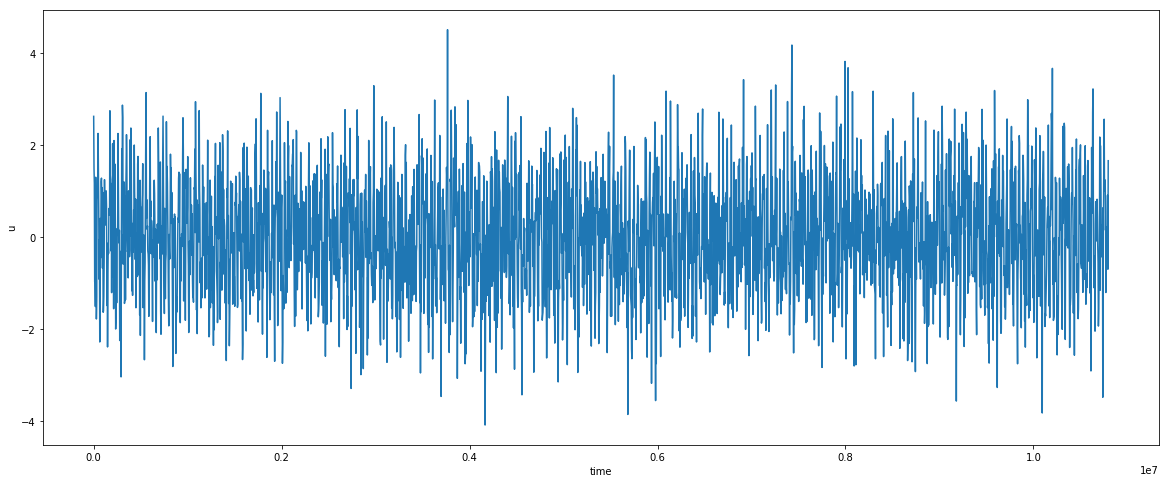

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
ds['u'].plot()

# Normal FFT

In [4]:
u_normal = ds['u']

u_fft_normal = xrft.dft(u_normal.fillna(0.), shift=False, detrend='linear', window=True)
E_u_normal = (u_fft_normal*u_fft_normal.conj()).where(u_fft_normal!=0., drop=False)
print(E_u_normal)
E_u_normal = E_u_normal.astype('f8').rename('u_power_spectrum')

<xarray.DataArray (freq_time: 3000)>
array([1796.099273+0.j, 2380.598236+0.j, 1044.573565+0.j, ...,  318.239584+0.j,
       1044.573565+0.j, 2380.598236+0.j])
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-08 1.852e-07 2.778e-07 ...
    freq_time_spacing  float64 9.259e-08


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


______

# FFT with a Hanning window (50% overlap windows)

In [5]:
E_dir = '/home1/scratch/xyu/mit_spec/'

nfft = 300
noverlap = nfft/2
window = np.hanning(nfft)

T = np.arange(0, len(ds['u'].time)-int(nfft/2), int(nfft/2))

for t in T:
    
    u = ds['u'].isel(time=slice(t,t+nfft))   
    u_fft = xrft.dft(window*u.fillna(0.), shift=False, detrend='linear', window=True)
    E_u = (u_fft*u_fft.conj()).where(u_fft!=0., drop=False)
    E_u = E_u.astype('f8').rename('E_u')
    file_E = E_dir+'E_u_t%04d.nc'%t 
    E_u.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWa

In [6]:
filenames = sorted(glob(E_dir+'E_u_t*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='blocks', compat='equals')
print(ds)

CPU times: user 60 ms, sys: 20 ms, total: 80 ms
Wall time: 83.1 ms
<xarray.Dataset>
Dimensions:            (blocks: 19, freq_time: 300)
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07
Dimensions without coordinates: blocks
Data variables:
    E_u                (blocks, freq_time) float64 dask.array<shape=(19, 300), chunksize=(1, 300)>


In [7]:
E = (ds.E_u).sum(dim='blocks') / len(ds.blocks)
print(E)

<xarray.DataArray 'E_u' (freq_time: 300)>
dask.array<shape=(300,), dtype=float64, chunksize=(300,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 9.259e-07 1.852e-06 2.778e-06 ...
    freq_time_spacing  float64 9.259e-07


No handles with labels found to put in legend.


(1.0, 10000.0)

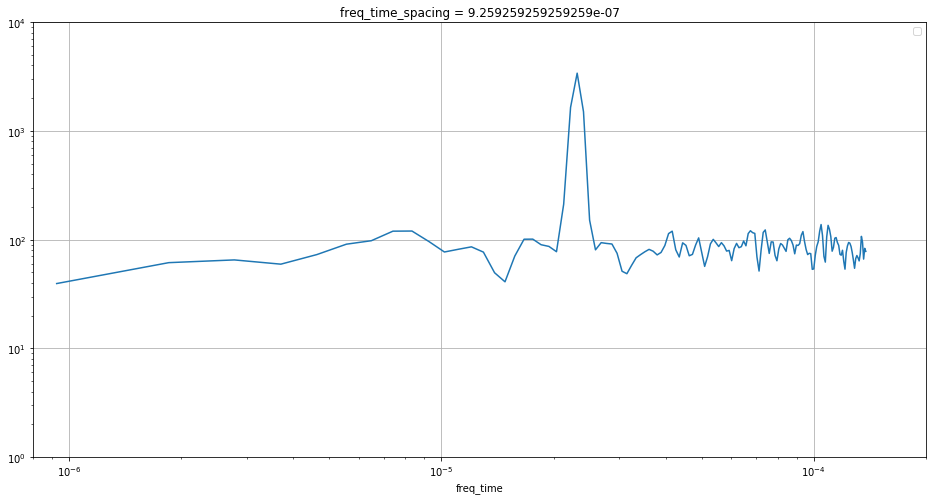

In [8]:
fig, ax = plt.subplots(figsize=(16,8))
E.where(E.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([8*1e-7,2*1e-4])
ax.set_ylim([1e0,1e4])

# Comparison

No handles with labels found to put in legend.


(1.0, 100000.0)

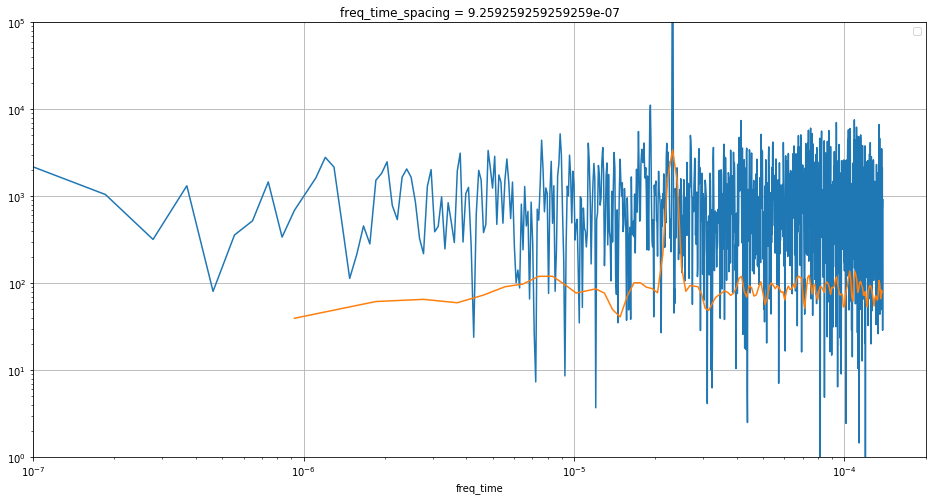

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
E_u_normal.where(E_u_normal.freq_time>0).plot(ax=ax)
E.where(E.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-7,2*1e-4])
ax.set_ylim([1e0,1e5])

# Xscale (Spectral test)

_______

In [5]:
import xscale.spectral.fft as xfft

In [25]:
u_time_spectrum = xfft.fft(u, dim='t', dx=1., detrend='mean', tapering=True, shift=False, sym=True)

In [26]:
u_time_spectrum

<xarray.DataArray 'spectrum' (f_t: 1000)>
dask.array<shape=(1000,), dtype=complex128, chunksize=(1000,)>
Coordinates:
  * f_t      (f_t) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
Attributes:
    ps_factor:   1e-06
    psd_factor:  0.001

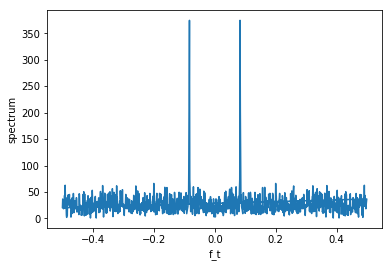

In [27]:
np.abs(u_time_spectrum).plot()

In [28]:
%time uv_complex = (ds['u'] + 1j*ds['v'])


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.31 ms


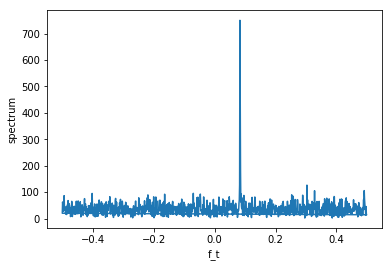

In [33]:
uv_time_spectrum = xfft.fft(uv_complex, dim='t', dx=1., detrend='mean', tapering=True, shift=False, sym=True)
np.abs(uv_time_spectrum).plot()

<xarray.DataArray 'spectrum' (f_t: 1000)>
dask.array<shape=(1000,), dtype=complex128, chunksize=(1000,)>
Coordinates:
  * f_t      (f_t) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/array/chunk.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(astype_dtype, **kwargs)


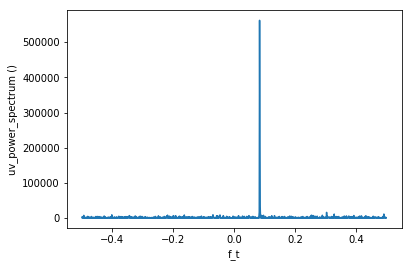

In [34]:
E_uv = (uv_time_spectrum*uv_time_spectrum.conj()).where(uv_time_spectrum!=0., drop=False)
print(E_uv)
E_uv = E_uv.astype('f8').rename('uv_power_spectrum ()')
np.abs(E_uv).plot()

In [ ]:
from xscale.spectral.tools import plot_spectrum

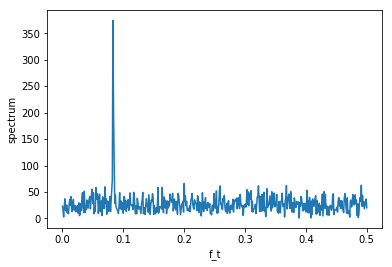

In [10]:
u_time_amplitude = xfft.amplitude(u_time_spectrum)
np.abs(u_time_amplitude).plot()


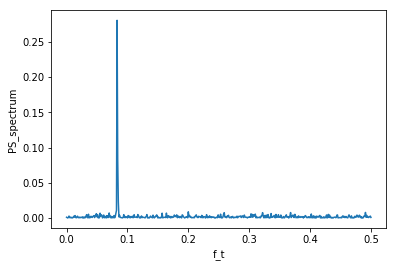

In [15]:
u_time_ps = xfft.ps(u_time_spectrum)
np.abs(u_time_ps).plot()


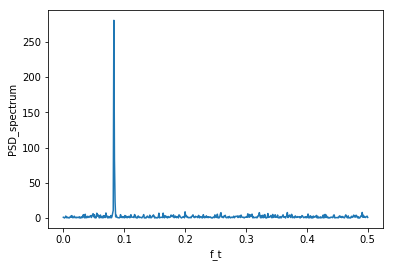

In [20]:
u_time_psd = xfft.psd(u_time_spectrum)
np.abs(u_time_psd).plot()


In [21]:
print(u_time_psd)

<xarray.DataArray 'PSD_spectrum' (f_t: 501)>
dask.array<shape=(501,), dtype=float64, chunksize=(501,)>
Coordinates:
  * f_t      (f_t) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 0.007 ...
Attributes:
    description:  Power Spectrum Density (PSD)


# Complex 

In [8]:
%time uv_complex = (ds['u'] + 1j*ds['v'])
print(uv_complex)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.84 ms
<xarray.DataArray (t: 1000)>
array([ 2.512593+0.438114j,  1.246063+0.531416j, -2.387463+0.694001j, ...,
        0.716301+1.226305j, -0.165184+1.607884j,  1.74936 -0.942426j])
Coordinates:
    time     (t) float64 0.0 3.6e+03 7.2e+03 1.08e+04 1.44e+04 1.8e+04 ...
Dimensions without coordinates: t


<xarray.DataArray (freq_t: 1000)>
array([4.290220e-26+0.j, 2.239723e+03+0.j, 3.079715e+02+0.j, ...,
       1.677480e+03+0.j, 2.276964e+03+0.j, 1.657979e+02+0.j])
Coordinates:
  * freq_t          (freq_t) float64 0.0 0.001 0.002 0.003 0.004 0.005 0.006 ...
    freq_t_spacing  float64 0.001


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xarray/core/ops.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


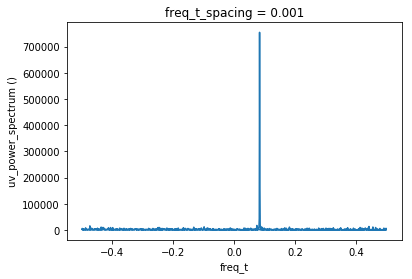

In [9]:
uv_fft = xrft.dft(uv_complex.fillna(0.), shift=False, detrend='linear')
E_uv = (uv_fft*uv_fft.conj()).where(uv_fft!=0., drop=False)
print(E_uv)
E_uv = E_uv.astype('f8').rename('uv_power_spectrum ()')
np.abs(E_uv).plot()

(10.0, 1000000.0)

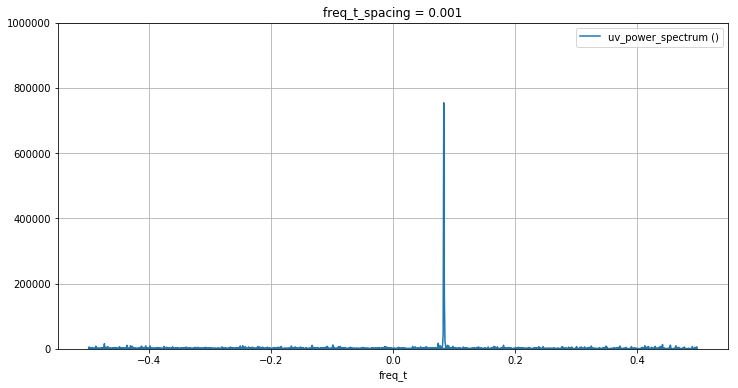

In [10]:

fig, ax = plt.subplots(figsize=(12,6))

E_uv.plot(ax=ax)
ax.legend(); ax.grid()
#ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

#ax.set_xlim([1.75*1e-3,1.75*1e-0])
ax.set_ylim([1e1,1e6])

